# **Модуль Б**. Разработка модели машинного обучения

## Импортирование библиотек

In [16]:
# модули для работы с моделью
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

from IPython.display import Audio

from Model.tokenizer import Tokenizer

import numpy as np

from IPython.display import Audio

import librosa
import librosa.display
import matplotlib.pyplot as plt

import math

from tqdm import tqdm  # Импортируем tqdm



## Загрузка данных

In [17]:
# путь к обработанным данным
df_path = '../Module1/Dataset/dataset.h5'
# загружаем датасета
df = pd.read_hdf(df_path, key='df')
df.head()

,token_ids,mel_spec
0,"[16, 11, 16, 0, 32, 11, 23, 10, 32, 26, 21, 32...","[[-56.18891, -54.528297, -43.841976, -44.33016..."
1,"[4, 25, 11, 15, 16, 29, 32, 15, 13, 30, 15, 16...","[[-55.704872, -55.704872, -55.704872, -55.7048..."
2,"[22, 7, 21, 10, 16, 24, 1, 32, 26, 28, 19, 26,...","[[-57.897354, -57.897354, -51.308334, -54.8423..."
3,"[27, 24, 25, 32, 26, 13, 24, 23, 32, 22, 10, 2...","[[-59.127876, -59.127876, -55.668625, -55.1438..."
4,"[15, 3, 16, 7, 17, 16, 24, 32, 4, 25, 9, 13, 2...","[[-50.631554, -50.631554, -50.631554, -50.6315..."


In [18]:
text_token_example = df['token_ids'][42]

print(text_token_example)

[21, 3, 17, 13, 9, 21, 0, 22, 15, 25, 0, 32, 22, 13, 31, 5, 32, 11, 28, 7, 21, 24, 32, 13, 22, 24, 16, 3, 16, 24, 1, 22, 29, 32, 26, 16, 11, 10, 31, 7, 16, 24, 21, 10, 21, 6, 32, 3, 32, 4, 21, 26, 21, 17, 16, 10, 1, 26, 13, 0, 32, 16, 22, 22, 16, 6, 11, 10, 21, 21, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34]


In [19]:
print(f'Макс размерность текста: {max([len(text_ids) for text_ids in df["token_ids"]])}')
print(f'Макс размерность mel-спектрограммы: {max([mel_spec.shape[1] for mel_spec in df["mel_spec"]])}')


Макс размерность текста: 99
Макс размерность mel-спектрограммы: 498


In [20]:
tokenizer = Tokenizer()
vocab_size = tokenizer.getlen()
print(f"Размер словаря: {vocab_size}")

d:\Helper\MLBazyak\chemp\Speech-synthesis\Module2
Размер словаря: 35


Структура VITS-lite

Text tokens → [Text Encoder] → hidden → [Decoder] → mel-spectrogram

## **Класс с датасетом**

In [21]:
# 1. Определяем Dataset
class TTSDataset(Dataset):
    def __init__(self, texts, mels):
        """
        texts: список или numpy массив токенизированных текстов, shape = (num_samples, T_text)
        mels: список или numpy массив мел-спектрограмм, shape = (num_samples, n_mels, T_mel)
        """
        self.texts = texts
        self.mels = mels
        
    # метод для получения длины датасета
    def __len__(self):
        return len(self.texts)
    
    # метод для получения элемента датасета
    def __getitem__(self, idx):
        text = torch.tensor(self.texts[idx], dtype=torch.long)
        mel = torch.tensor(self.mels[idx], dtype=torch.float32)
        return text, mel

In [22]:
tokenized_texts = df['token_ids']
mel_spectrograms = df['mel_spec']


In [23]:
PAD_IDX = 34

In [24]:
# Создаем DataLoader
dataset = TTSDataset(tokenized_texts, mel_spectrograms)

In [25]:
# Проверяем один пример
tokens, mel = dataset[0]
print("Пример 0:")
print(f"Токены: {tokens} (длина: {len(tokens)})")
print(f"Спектрограмма: {mel.shape}")

Пример 0:
Токены: tensor([16, 11, 16,  0, 32, 11, 23, 10, 32, 26, 21, 32, 24, 13, 10,  1, 15, 13,
        32, 24, 16, 10, 16, 26, 24, 10, 25,  3, 23,  6, 32,  9, 13, 27, 24, 13,
         6, 32, 26, 13, 32, 25, 32, 28, 20, 21, 26, 23,  6, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34]) (длина: 99)
Спектрограмма: torch.Size([80, 498])


Маска внимания *(0 - токен паддинга)*

In [26]:
text_mask = (tokens != PAD_IDX).int()
text_mask

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=torch.int32)

In [27]:
# функция для коллатора, которая паддит последовательности в батче
def collate_fn(batch):
    texts, mels = zip(*batch)
    # паддинг текстов и мел-спектрограмм до макс длины в батче
    text_padded = pad_sequence(texts, batch_first=True, padding_value=PAD_IDX)
    mels_padded = pad_sequence(mels, batch_first=True, padding_value=-80.0)
    return text_padded, mels_padded

In [32]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=8, collate_fn=collate_fn)

In [33]:
# Проверяем батч
for batch_idx, (tokens_batch, mels_batch) in enumerate(dataloader):
    print(f"\nБатч {batch_idx}:")
    print(f"Токены: {tokens_batch.shape}")
    print(f"Спектрограммы: {mels_batch.shape}")
    break


Батч 0:
Токены: torch.Size([8, 99])
Спектрограммы: torch.Size([8, 80, 498])


In [36]:
class TTSDataset(Dataset):
    def __init__(self, texts, mels, text_lengths=None, mel_lengths=None):
        """
        texts: список токенизированных текстов (num_samples, T_text)
        mels: список мел-спектрограмм (num_samples, n_mels, T_mel)
        text_lengths: реальные длины текстов (для маскирования)
        mel_lengths: реальные длины спектрограмм (для маскирования)
        """
        self.texts = texts
        self.mels = mels
        self.text_lengths = text_lengths if text_lengths else [len(t) for t in texts]
        self.mel_lengths = mel_lengths if mel_lengths else [m.shape[1] for m in mels]
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return {
            "text": torch.tensor(self.texts[idx], dtype=torch.long),
            "mel": torch.tensor(self.mels[idx], dtype=torch.float32),
            "text_len": self.text_lengths[idx],
            "mel_len": self.mel_lengths[idx]
        }

def collate_fn(batch):
    texts = [item["text"] for item in batch]
    mels = [item["mel"] for item in batch]
    text_lens = torch.tensor([item["text_len"] for item in batch])
    mel_lens = torch.tensor([item["mel_len"] for item in batch])
    
    # Паддинг с сохранением информации о реальных длинах
    text_padded = pad_sequence(texts, batch_first=True, padding_value=PAD_IDX)
    mel_padded = pad_sequence(mels, batch_first=True, padding_value=-80.0)
    
    # Маски для внимания и потерь
    text_mask = (text_padded != PAD_IDX).float()
    mel_mask = torch.ones_like(mel_padded[:, 0, :])  # (B, T_mel)
    for i, l in enumerate(mel_lens):
        mel_mask[i, l:] = 0
        
    return {
        "texts": text_padded,
        "mels": mel_padded,
        "text_lens": text_lens,
        "mel_lens": mel_lens,
        "text_mask": text_mask,
        "mel_mask": mel_mask
    }

# Пример использования
dataset = TTSDataset(tokenized_texts, mel_spectrograms)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [39]:
# Параметры
vocab_size = vocab_size      # пример размера словаря
n_mels = 80           # число мел-коэффициентов
batch_size = 2
T_text = 99           # длина текстовой последовательности
T_mel = 498           # временная длина мел-спектрограммы

# # Генерируем случайные данные для демонстрации:
# text = torch.randint(0, vocab_size, (batch_size, T_text))
# # Имитация мел-спектрограмм (например, предварительно извлечённых)
# mel = torch.randn(batch_size, n_mels, T_mel)

## **Класс с моделью**

In [41]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [46]:
class TTSModel(nn.Module):
    def __init__(self, vocab_size, n_mels=80):
        super().__init__()
        # Encoder
        self.embedding = nn.Embedding(vocab_size, 256, padding_idx=PAD_IDX)
        self.encoder = nn.LSTM(256, 128, bidirectional=True)
        
        # Mel processing
        self.prenet = nn.Sequential(
            nn.Linear(n_mels, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128)
        )
        
        # Attention
        self.attention = nn.MultiheadAttention(embed_dim=128, num_heads=4)
        
        # Decoder
        self.decoder = nn.LSTM(256, 128)  # 128 (attention) + 128 (prenet)
        self.mel_proj = nn.Linear(128, n_mels)

    def forward(self, texts, text_lens, mels=None, mel_lens=None):
        # Text encoder
        x = self.embedding(texts)
        x = pack_padded_sequence(x, text_lens.cpu(), batch_first=True, enforce_sorted=False)
        enc_out, _ = self.encoder(x)
        enc_out, _ = pad_packed_sequence(enc_out, batch_first=True)  # (B, T_text, 256)
        
        if mels is not None:
            # Prenet for mels
            mels = mels.transpose(1, 2)  # (B, T_mel, n_mels)
            mels = self.prenet(mels)  # (B, T_mel, 128)
            
            # Prepare masks
            text_mask = (torch.arange(texts.size(1)).to(texts.device) >= text_lens.unsqueeze(1))
            mel_mask = (torch.arange(mels.size(1)).to(mels.device) >= mel_lens.unsqueeze(1))
            
            # Attention (B, T_mel, 128)
            attn_out, _ = self.attention(
                query=mels.transpose(0, 1),  # (T_mel, B, 128)
                key=enc_out.transpose(0, 1),  # (T_text, B, 256)
                value=enc_out.transpose(0, 1),
                key_padding_mask=text_mask
            )
            attn_out = attn_out.transpose(0, 1)  # (B, T_mel, 128)
            
            # Decoder
            dec_input = torch.cat([attn_out, mels], dim=-1)  # (B, T_mel, 256)
            dec_out, _ = self.decoder(dec_input)  # (B, T_mel, 128)
            
            # Project to mel
            mel_out = self.mel_proj(dec_out).transpose(1, 2)  # (B, n_mels, T_mel)
            return mel_out
        
        return enc_out

In [47]:
model = TTSModel(vocab_size=vocab_size, n_mels=80)
model.to(device)

TTSModel(
  (embedding): Embedding(35, 256, padding_idx=34)
  (encoder): LSTM(256, 128, bidirectional=True)
  (prenet): Sequential(
    (0): Linear(in_features=80, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
  )
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (decoder): LSTM(256, 128)
  (mel_proj): Linear(in_features=128, out_features=80, bias=True)
)

In [48]:
# 2. Определение loss и оптимизатора
# ----------------------------------------------------------------------------
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()  # L1 loss часто используется для регрессии мел-спектрограмм

In [45]:
# # Прямой проход
# pred_mel, durations, h_prior, z_post = model(text, mel)
# print("Предсказанная мел-спектрограмма:", pred_mel.shape)   # Ожидается (batch, n_mels, T_mel)
# print("Длительности:", durations.shape)                     # (batch, T_text)
# print("Prior:", h_prior.shape)                              # (batch, hidden_dim, T_target)
# print("Posterior latent:", z_post.shape)                    # (batch, hidden_dim, T_mel)

In [50]:
# 5. Цикл обучения

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for text_batch, mel_batch in pbar:
        text_batch = text_batch.to(device)    # (batch, T_text)
        mel_batch = mel_batch.to(device)        # (batch, n_mels, T_mel)
        optimizer.zero_grad()
        pred_mel, durations, h_prior = model(text_batch, mel_batch)

        loss = criterion(pred_mel, mel_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}: Average Loss: {avg_loss:.4f}")

Epoch 1/20:   0%|          | 0/293 [00:00<?, ?batch/s]


ValueError: too many values to unpack (expected 2)

In [64]:
def invert_mel(mel_db, sr=16000, n_fft=1024, hop_length=256, n_iter=32):
    """
    Преобразует мел-спектрограмму (в dB) обратно в аудиосигнал с использованием Griffin-Lim.
    
    Параметры:
      mel_db: Мел-спектрограмма в dB (numpy.ndarray)
      sr: Частота дискретизации (по умолчанию 16000)
      n_fft: Размер окна FFT (по умолчанию 1024)
      hop_length: Шаг окна (по умолчанию 256)
      n_iter: Количество итераций алгоритма Griffin-Lim (по умолчанию 32)
    
    Возвращает:
      y: Восстановленная аудиоволна (numpy.ndarray)
    """
    # Преобразуем из dB обратно в power
    mel_power = librosa.db_to_power(mel_db, ref=1.0)
    
    # восстановление аудио сигнала
    y = librosa.feature.inverse.mel_to_audio(
        M=mel_power,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_iter=n_iter
    )
    
    return y

In [83]:
mel_spectrograms[0].shape

(80, 498)

In [84]:
Audio(invert_mel(mel_spectrograms[0]), rate=16000)

In [66]:
def token_padding(token_ids: list, vocab: dict = tokenizer.text_to_ids_voc, max_len: int = 99, ):
    while len(token_ids) != max_len:
        token_ids.append(vocab.get('<pad>'))
    return token_ids


In [85]:
text = df['token_ids'][0]
print(text)
print(f'target mel-gram shape: {df["mel_spec"][0].shape}')

[16, 11, 16, 0, 32, 11, 23, 10, 32, 26, 21, 32, 24, 13, 10, 1, 15, 13, 32, 24, 16, 10, 16, 26, 24, 10, 25, 3, 23, 6, 32, 9, 13, 27, 24, 13, 6, 32, 26, 13, 32, 25, 32, 28, 20, 21, 26, 23, 6, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34]
target mel-gram shape: (80, 498)


In [86]:
# Получаем предсказанные мел-спектрограммы от модели
model.eval()
with torch.no_grad():
    pred_mel, durations, h_prior = model(text_batch)  # Получаем предсказание из модели

In [87]:
print("Durations:", durations)  # <- Какие значения предсказаны?
print("Sum durations:", durations.sum())

Durations: tensor([[ 0.0903,  0.1116, -0.0426,  0.0020, -0.0756,  0.0899, -0.1463,  0.1203,
         -0.0994, -0.0278,  0.0268,  0.0310, -0.0941, -0.0210,  0.1243,  0.0570,
         -0.0195,  0.1060,  0.0085, -0.0171,  0.0606,  0.0848, -0.0062,  0.0703,
         -0.0117,  0.1089,  0.0516,  0.0569, -0.0910,  0.0371, -0.0297, -0.0224,
          0.0496,  0.0150,  0.0141,  0.0280,  0.0906,  0.0542, -0.0161,  0.0381,
          0.1475, -0.0006,  0.0961,  0.0710,  0.1184,  0.0585,  0.1095,  0.0923,
          0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,
          0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,
          0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,
          0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,
          0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,
          0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,
          0.0685,

In [88]:
pred_mel.shape

torch.Size([1, 80, 99])

In [89]:
pred_mels_np = pred_mel.detach().cpu().numpy()
print(pred_mels_np.shape)
pred_mels_np_T = pred_mels_np.squeeze(0).T 
pred_mels_np_T = torch.nn.functional.interpolate(
                pred_mel, size=mel_spectrograms[0].shape[-1], mode="linear", align_corners=False
            )
print(pred_mels_np_T.detach().cpu().numpy().shape)

(1, 80, 99)
(1, 80, 498)


In [90]:
y = invert_mel(pred_mels_np_T.detach().cpu().numpy())
y

array([[ 0.128308  ,  0.28800216,  0.06370329, ..., -0.06695668,
         0.32469797,  0.04823967]], dtype=float32)

In [91]:
y_target = invert_mel(df['mel_spec'][0])
y_target

array([-2.7501053e-05,  3.0485648e-04,  1.5856112e-04, ...,
       -1.6679214e-05, -1.0877101e-05,  3.1890292e-07], dtype=float32)

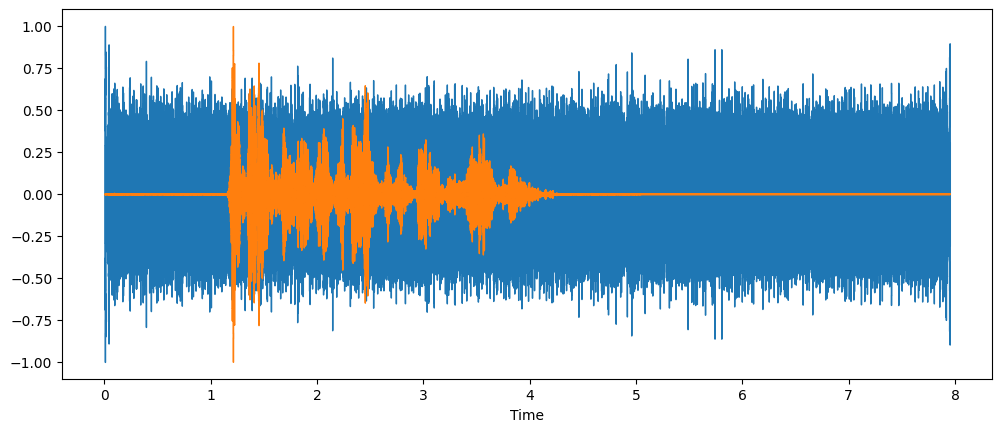

In [92]:
plt.figure().set_figwidth(12)
librosa.display.waveshow(y, sr=16000)
librosa.display.waveshow(y_target, sr=16000)

In [224]:
Audio(y, rate=16000)

In [29]:
import soundfile as sf
sf.write('output6.wav', y, 16000)  # Транспонируем для soundfile

In [167]:
torch.save(model.state_dict(), 'tts_model_words1.pth')  # Только веса
# ИЛИ
torch.save(model, 'tts_model_full_word1.pt')  # Веса + архитектура

In [ ]:
# Для state_dict
model = TTSTransformer(vocab_size, d_model=256, n_mels=80)
model.load_state_dict(torch.load('tts_model.pth'))
model.eval()

# Для полной модели
model = torch.load('tts_model_full.pt')
model.eval()

In [150]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity(y.reshape(-1, 1), df['array'][0].reshape(-1, 1))